# Visual Odometry
This notebook is for visual odometry that apply stereo vision depth estimation and multiple view geometry for tracking vehicle position and orientation within a sequence of image for kitti dataset.

In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
from pathlib import Path
from typing import Iterator, Optional, Literal

from dotenv import load_dotenv

_ = load_dotenv()

## Dataset Handler

Create a dataset handler object that could help load left and right images with generator, and also load ground truth poses and calibration matrics

In [2]:
class DatasetHandler(object):
    def __init__(self) -> None:
        self.l_dir: Path = Path(os.getenv('img_l_dir'))
        self.r_dir: Path = Path(os.getenv('img_r_dir'))
        self.l_files: list = sorted(self.l_dir.glob('*.png'), key=lambda f: int(f.stem))
        self.r_files: list = sorted(self.r_dir.glob('*.png'), key=lambda f: int(f.stem))
        self.frame_num: int = len(self.l_files)

        # Load ground truth poses
        poses = pd.read_csv(os.getenv('poses_file'), delimiter=' ', header=None)
        self.gt: np.ndarray = poses.values.reshape((-1, 3, 4))

        # Load camera calibration matrices
        calib = pd.read_csv(os.getenv('calib_file'), delimiter=' ', header=None, index_col=0)
        self.K0, self.K1, self.Tr = [
            np.array(calib.loc[x, :]).reshape((3, 4)) for x in ('P0:', 'P1:', 'Tr:')
        ]

        self._reset_frame()

    def next_frame(self) -> tuple:
        self.l_prev, self.r_prev, self.l_curr = (
            self.l_curr,
            next(self.r_imgs),
            next(self.l_imgs)
        )
        return self.l_prev, self.r_prev, self.l_curr

    @property
    def imsize(self) -> tuple[int, int]:
        return self.ih, self.iw    

    def _reset_frame(self) -> None:
        self.l_imgs: Iterator[cv2.Mat] = (cv2.imread(str(f), 0) for f in self.l_files)
        self.r_imgs: Iterator[cv2.Mat] = (cv2.imread(str(f), 0) for f in self.r_files)
        
        self.l_curr = next(self.l_imgs)
        self.ih, self.iw = self.l_curr.shape

Create a `WLidarHandler`, which means with lidar dataset handler, that inheritant from dataset handler. Make it available to load point cloud data from map

In [3]:
class WLidarHandler(DatasetHandler):
    def __init__(self) -> None:
        super().__init__()
        self.pcd: Path = Path(os.getenv('lidar_dir'))
        self.pcf: list = sorted(self.pcd.glob('*.bin'), key=lambda f: int(f.stem))
        self.pcl: Iterator[np.ndarray] = (
            np.fromfile(f, dtype=np.float32, count=-1) for f in self.pcf
        )

    def next_frame(self) -> None:
        super().next_frame()
        self.lidar: np.ndarray = next(self.pcl)
        return self.l_prev, self.r_prev, self.l_curr, self.lidar

Total frame number: 1106.


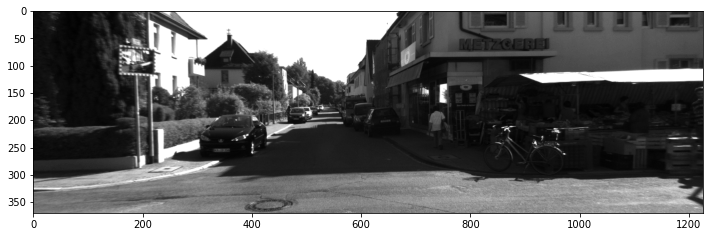

In [24]:
h = DatasetHandler()
l_img, *_ = h.next_frame()

print(f'Total frame number: {h.frame_num}.')

plt.figure(figsize=(12, 6))
plt.imshow(l_img, cmap='gray')
plt.show()

With the dataset handler, we could keep upload image (and point cloud) data from files. `next_frame()` methods return **left_image** and **right_image** at time `t` for stereo vision, and **left_image** at time `t+1` for transformation estimation.  

## Visual Odometry
After obtaining 3D points $\mathbf P_c$ in camera coordinate by stereo depth estimation, we need to estimate the camera motion $(R, t)$ by aligning these 3D points with their corresponding 2D observations $\mathbf p=(u'.v')$ in the second image. The transformation from the initial camera coordinate system to the new camera coordinate system is:

$$
\mathbf P'_c=R\mathbf P_c+t
$$

In the second image, the projected 2D points are:

$$
\begin{bmatrix}u'\\ v'\\1 \end{bmatrix} \sim \mathbf K(R\mathbf P_c+t)
$$

This equation forms the basis of the PnP problem: given 3D-2D correspondences $(\mathbf P_c, \mathbf p')$, and estimate $R$ and $t$.

The `cv2.solvePnPRansac` function solves this problem by minimizing the **reprojection error**, which measures how well the projected 3D points align with the observed 2D keypoints:

$$
\sum_i ||\mathbf p'_i-\pi (R\mathbf P_{ci}+t)||^2
$$

where $\pi(\cdot)$ is the projection function. Besides, **RANSAC (Random Sample Consensus)** is applied to improve robustness by iteratively selecting random subsets of correspondences, solving for $R,t$, and discarding outliers.

In [15]:
class VisualOdometry(object):
    def __init__(
        self, 
        P0: np.ndarray,
        P1: np.ndarray,
        Tr: np.ndarray,
        isize: tuple[int, int],
        lidar: bool = False,
        stereo_matcher: Optional[Literal['bm', 'sgbm']] = None,
        detector: Literal['orb', 'sift'] = 'orb',
        matching: Literal['bf', 'flann'] = 'bf',
        matching_threshold: Optional[float] = None
    ) -> None:
        self.P0, self.P1, self.Tr = P0, P1, Tr
        self.K0, _, self.t0, *_ = cv2.decomposeProjectionMatrix(self.P0)
        self.K1, _, self.t1, *_ = cv2.decomposeProjectionMatrix(self.P1)
        self.f = self.K0[0, 0]
        self.b = self.t1[0] - self.t0[0]
        self.ih, self.iw = isize
        self.cx, self.cy = self.K0[0, 2], self.K0[1, 2]
        self.fx, self.fy = self.K0[0, 0], self.K0[1, 1]

        # Stereo matcher
        self._lidar: bool = lidar
        self._stereo_matcher: Optional[cv2.StereoBM | cv2.StereoSGBM] = None
        if stereo_matcher == 'sgbm':
            self._stereo_matcher = cv2.StereoSGBM.create(
                numDisparities=96,
                minDisparity=0,
                blockSize=11,
                P1 = 8 * 3 * 6 ** 2, 
                P2 = 32 * 3 * 6 ** 2,
                mode=cv2.STEREO_SGBM_MODE_SGBM_3WAY
            )
        elif stereo_matcher == 'bm':
            self._stereo_matcher = cv2.StereoBM.create(numDisparities=96, blockSize=11)

        # Feature detector and matcher
        self._feature_detector: cv2.ORB | cv2.SIFT = {
            'orb': cv2.ORB.create, 
            'sift': cv2.SIFT.create
        }[detector]()
        
        if matching == 'bf':
            self._feature_matcher = cv2.BFMatcher.create(
                cv2.NORM_L2 if detector == 'sift' else cv2.NORM_HAMMING2,
                crossCheck=False
            )
        else:
            self._feature_matcher = cv2.FlannBasedMatcher(
                dict(algorithm=1, trees=5), 
                dict(checks=50)
            )
        self.threshold: Optional[float] = matching_threshold

        # Trajectory
        self.T: np.ndarray = np.eye(4)
        self.traj: np.ndarray = np.zeros((1, 3, 4))
        self.traj[0] = self.T[:3, :]

    def update(
        self,
        image_l0: np.ndarray,
        image_r0: np.ndarray,
        image_l1: np.ndarray,
        point_clould: Optional[np.ndarray] = None
    ) -> None:
        depth: Optional[np.ndarray] = None
        if self._stereo_matcher:
            depth = self._depth_estimate(image_l0, image_r0, point_clould)

        kp0, des0 = self._feature_detector.detectAndCompute(image_l0, None)
        kp1, des1 = self._feature_detector.detectAndCompute(image_l1, None)

        matches = self._features_matching(des0, des1)
        R, t = self._motion_estimate(kp0, kp1, matches, depth)

        T_hom: np.ndarray = np.eye(4)
        T_hom[:3, :3], T_hom[:3, 3] = R, t.T
        self.T = self.T @ np.linalg.inv(T_hom)
        self.traj = np.vstack((self.traj, self.T[:3, :][np.newaxis]))
        
    def _depth_estimate(
        self, 
        image_l0: np.ndarray,
        image_r0: np.ndarray,
        point_clould: Optional[np.ndarray] = None
    ) -> np.ndarray:
        disp = self._stereo_matcher.compute(image_l0, image_r0).astype(np.float32) / 16
        disp = np.maximum(disp, 0.1)
        
        depth = (self.f * self.b) / disp
        if not point_clould is None or not self._lidar:
            return depth
        
        # Lidar depth correction
        pcl = point_clould[point_clould[:, 0] > 0]
        cam = self.Tr @ np.c_[pcl[:, :3], np.ones(len(pcl))].T
        cam = cam[:, cam[2] > 0]

        pixel_coord = (self.P0 @ cam / cam[2]).T[:, :2].round().astype(int)
        valid_pixels = (0 <= pixel_coord[:, 0]) & (pixel_coord[:, 0] < self.iw) & \
                       (0 <= pixel_coord[:, 1]) & (pixel_coord[:, 1] < self.ih)
    
        depth_map = np.full((self.ih, self.iw), 3000, dtype=np.float32)
        depth_map[pixel_coord[valid_pixels, 1], pixel_coord[valid_pixels, 0]] = cam[2, cam[2] > 0][valid_pixels]

        # Apply corrected LiDAR depth where available
        mask = depth_map < 3000
        depth[mask] = depth_map[mask]
    
        return depth

    def _features_matching(
        self,
        des1: np.ndarray,
        des2: np.ndarray,
    ) -> list[cv2.DMatch]:
        matches = self._feature_matcher.knnMatch(des1, des2, 2)
        matches = sorted(matches, key=lambda x: x[0].distance)

        return [
            m for m, n in matches 
            if self.threshold is None or m.distance <= n.distance * self.threshold
        ]
    
    def _motion_estimate(
        self,
        kp1: list[cv2.KeyPoint],
        kp2: list[cv2.KeyPoint],
        matches: list[cv2.DMatch],
        depth: Optional[np.ndarray] = None,
        depth_max: int = 3000
    ) -> tuple[np.ndarray, np.ndarray]:
        R: np.ndarray = np.eye(3)
        t: np.ndarray = np.zeros((3, 1))

        pts_1 = np.float32([kp1[m.queryIdx].pt for m in matches])
        pts_2 = np.float32([kp2[m.trainIdx].pt for m in matches])

        if depth is None: # apply essential matrix decomposition, scale ambiguous
            E, _ = cv2.findEssentialMat(pts_1, pts_2, self.K0)
            _, R, t, _ = cv2.recoverPose(E, pts_1, pts_2, self.K0)
            return R, t
        
        ## convert points in image1 into world coordinate with camera parameter and
        ## depth information, apply PnP algorithm with RANSAC for robustness to outlier
        pts_w = np.zeros((0, 3), dtype=np.float32)
        remove_idx: list[int] = []

        for i, (u, v) in enumerate(pts_1):
            z = depth[int(v), int(u)]
            if z > depth_max:
                remove_idx.append(i)
                continue

            x = z * (u - self.cx) / self.fx
            y = z * (v - self.cy) / self.fy
            pts_w = np.vstack([pts_w, np.array([x, y, z])])

        pts_2 = np.delete(pts_2, remove_idx, 0)
        _, R_vec, t, _ = cv2.solvePnPRansac(pts_w, pts_2, self.K0, None)
        R = cv2.Rodrigues(R_vec)[0]
        return R, t


The estimated rotation $R_\text{vec}$ is represented as a **Rodrigues rotation vector**, which parameterizes rotation as a 3D vector:

$$
R_\text{vec}=\theta \hat{\mathbf r}
$$

Where $\hat{\mathbf r}$ is the unit axis of rotation and $\theta$ is the rotation angle. To convert this into a rotation matrix, we use **Rodrigues’ formula**:

$$
R=I+\sin\theta \mathbf K+(1-\cos \theta)\mathbf K^2
$$

Where $\mathbf K$ is the skew-symmetric matrix of $R_\text{vec}$ via `hat operator`:

$$
\hat{R_\text{vec}}=\mathbf K=\begin{bmatrix} 
0&-r_z&r_y\\r_z&0&-r_x\\-r_y&r_x&0
\end{bmatrix}
$$

OpenCV provide a useful funtion `cv2.Rodrigues(R_vec)` to convert automatically.

## Trajectory Evaluation

Create a trajectory evaluator that help compute error between estimated trajectory and ground truth, and also plot the trajectory in graph.

In [ ]:
class TrajectoryEvaluator(object):
    def __init__(self, gt: np.ndarray, es: np.ndarray) -> None:
        if es.shape[0] == 0:
            raise ValueError("Estimation is empty.")
        
        self.gt: np.ndarray = gt
        self.es: np.ndarray = es

    def error(self) -> None:
        n: int = min(len(self.gt) - 1, self.es.shape[0])
        ae: float = np.linalg.norm(self.gt[n, :3, 3] - self.es[n, :3, 3])
        se: float = np.power(ae, 2)
        print(f"MSE: {se:.4f}, MAE: {ae:.4f}, RMSE: {np.sqrt(se):.4F}.")

    def plot(self) -> None:
        fig = plt.figure(figsize=(10, 6))
        ax = fig.add_subplot(111, projection='3d')

        ax.plot(self.es[:, :, 3][:, 0],
                self.es[:, :, 3][:, 1],
                self.es[:, :, 3][:, 2],
                label='estimation', color='orange', linewidth=2)

        ax.plot(self.gt[:, :, 3][:, 0],
                self.gt[:, :, 3][:, 1],
                self.gt[:, :, 3][:, 2],
                label='ground truth', linewidth=2)

        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.set_zlabel('z')
        ax.view_init(elev=40, azim=60)
        ax.legend()

        plt.show()

Given a set of **ground truth** poses $\mathbf T_{gt}$ and **estimated** poses $\mathbf T_{es}$, the position error at time step $i$ is:

$$
e_i=||t_{gt_i}-t_{es_i}||
$$

where $t_{gt_i}$ and $t_{es_i}$ are the **translation vectors** extracted from the 4×4 transformation matrices. And then we could compute corresponding **mean absolute error**, **mean squared error**, and **root mean squared error**.

## Experiment

In [16]:
%matplotlib inline

handler = DatasetHandler()
vo = VisualOdometry(
    handler.K0,
    handler.K1,
    handler.Tr,
    handler.imsize,
    detector='sift',
    matching='flann',
    matching_threshold=0.45
)

for _ in tqdm(range(handler.frame_num - 1)):
    image0, image1, image2 = handler.next_frame()
    vo.update(image0, image1, image2)

100%|██████████| 1105/1105 [04:39<00:00,  3.96it/s]


In [17]:
eval = TrajectoryEvaluator(handler.gt, vo.traj)
eval.error()

MSE: 216672.1370, MAE: 465.4805, RMSE: 465.4805.


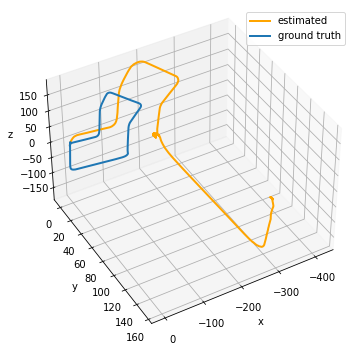

In [18]:
eval.plot()

In [19]:
%matplotlib inline
handler = DatasetHandler()
vo = VisualOdometry(
    handler.K0,
    handler.K1,
    handler.Tr,
    handler.imsize,
    stereo_matcher='sgbm',
    matching_threshold=0.5
)

for _ in tqdm(range(handler.frame_num - 1)):
    image0, image1, image2 = handler.next_frame()
    vo.update(image0, image1, image2)

100%|██████████| 1105/1105 [01:05<00:00, 16.98it/s]


In [20]:
eval = TrajectoryEvaluator(handler.gt, vo.traj)
eval.error()

MSE: 1349.1168, MAE: 36.7303, RMSE: 36.7303.


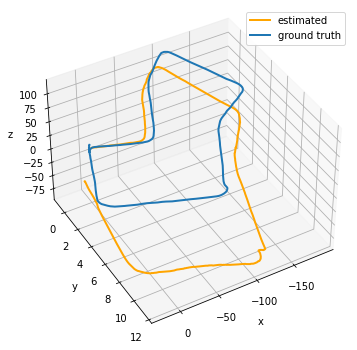

In [21]:
eval.plot()

In [ ]:
%matplotlib inline

handler = DatasetHandler(lidar=True)
vo = VisualOdometry(
    handler.K0,
    handler.K1,
    handler.Tr,
    handler.imsize,
    lidar=True,
    stereo_matcher='sgbm',
    detector='sift',
    matching_threshold=0.5
)

for _ in tqdm(range(handler.frame_num - 1)):
    image0, image1, image2, pcl = handler.next_frame()
    vo.update(image0, image1, image2, pcl)

In [ ]:
eval = TrajectoryEvaluator(handler.gt, vo.traj)
eval.error()

In [ ]:
eval.plot()